# Testing AudioMPS class

In [1]:
import sys
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

sys.path.append("../")

from model import AudioMPS

In [2]:
sess = tf.InteractiveSession()

## Load Data

In [3]:
BATCH_SIZE = 32

In [4]:
guitar_dataset = tf.data.TFRecordDataset('../data/guitar.tfrecords')

In [5]:
parse_function = lambda example_proto: tf.parse_single_example(example_proto,
                                                               {"audio": tf.FixedLenFeature([2**16], dtype=tf.float32)})

In [6]:
guitar_dataset = guitar_dataset.map(parse_function)  # Parse the record into tensors.

In [7]:
guitar_dataset = guitar_dataset.batch(batch_size=BATCH_SIZE).shuffle(buffer_size=10000).repeat()
guitar_iterator = guitar_dataset.make_one_shot_iterator()
guitar_batch = guitar_iterator.get_next()

In [8]:
guitar_batch['audio']

<tf.Tensor 'IteratorGetNext:0' shape=(?, 65536) dtype=float32>

An example waveform

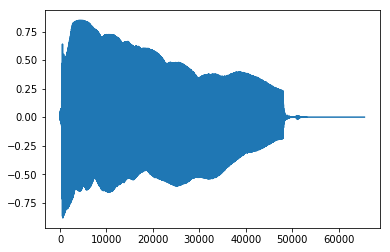

In [9]:
plt.plot(sess.run(guitar_batch['audio'])[0])

Close up

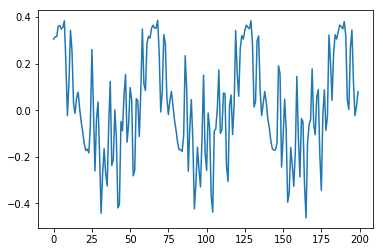

In [10]:
plt.plot(sess.run(guitar_batch['audio'])[0][20000:20200])

Here's the derivative

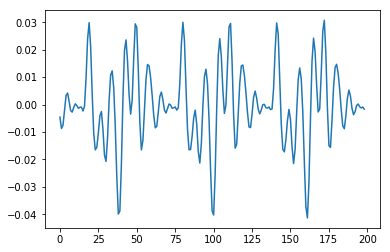

In [11]:
plt.plot(np.diff(sess.run(guitar_batch['audio'])[0][20000:20200]))

## Checking the loss works

In [12]:
BOND_D = 5

In [13]:
with tf.variable_scope("guitar_model"):
    guitar_model = AudioMPS(BOND_D, delta_t=0.01, data_iterator=guitar_batch['audio'])

In [14]:
sess.run(tf.global_variables_initializer())

In [15]:
sess.run(guitar_model.loss)

298.3894

## Training

### Sine wave with random phase and decay

In [16]:
INPUT_LENGTH = 2**12
BATCH_SIZE = 8
with tf.variable_scope("sine_model_data", reuse=tf.AUTO_REUSE):
    range_stack = tf.stack(BATCH_SIZE * [tf.range(INPUT_LENGTH,dtype=np.float32)])
    sine_wave_random_phase = tf.sin(range_stack / 10 + 
                                    tf.random_uniform([BATCH_SIZE,1],minval=0,maxval=2*np.pi))* tf.exp(-0.001*tf.range(INPUT_LENGTH,dtype=np.float32))

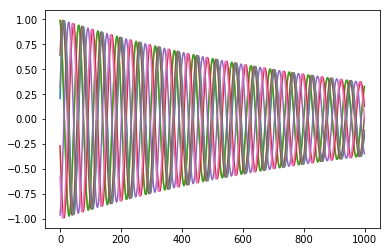

In [17]:
for wave in sess.run(sine_wave_random_phase):
    plt.plot(wave[:1000])

In [19]:
BOND_D = 5
with tf.variable_scope("sine_model", reuse=tf.AUTO_REUSE):
    sine_model = AudioMPS(BOND_D, delta_t=0.01, data_iterator=sine_wave_random_phase)

Try training with the TF training script... does everything for us.

First add some summaries that we will track during training

In [20]:
tf.summary.scalar("loss_function", tf.reshape(sine_model.loss, []))
tf.summary.audio("sample_inputs", sine_wave_random_phase, sample_rate=16000, max_outputs=1)

<tf.Tensor 'sample_inputs:0' shape=() dtype=string>

In [21]:
step = tf.get_variable("global_step", [], tf.int64, tf.zeros_initializer(), trainable=False)
train_op = tf.train.AdamOptimizer(1e-3).minimize(sine_model.loss, global_step=step)

In [22]:
tf.contrib.training.train(train_op, logdir="../logging", save_checkpoint_secs=60)

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into ../logging/model.ckpt.
INFO:tensorflow:Saving checkpoints for 40 into ../logging/model.ckpt.
INFO:tensorflow:Saving checkpoints for 80 into ../logging/model.ckpt.
INFO:tensorflow:global_step/sec: 0.664597
INFO:tensorflow:Saving checkpoints for 121 into ../logging/model.ckpt.
INFO:tensorflow:Saving checkpoints for 162 into ../logging/model.ckpt.
INFO:tensorflow:global_step/sec: 0.68187
INFO:tensorflow:Saving checkpoints for 204 into ../logging/model.ckpt.
INFO:tensorflow:Saving checkpoints for 246 into ../logging/model.ckpt.
INFO:tensorflow:Saving checkpoints for 287 into ../logging/model.ckpt.
INFO:tensorflow:global_step/sec: 0.689832
INFO:tensorflow:Saving checkpoints for 329 into ../logging/model.ckpt.
INFO:tensorflow:Saving checkpoints for 371 into ../logging/model.ckpt.
INFO:

KeyboardInterrupt: 

## Sampling 

Load the trained model into the current session.

In [24]:
BOND_D = 5
with tf.variable_scope("sine_model", reuse=tf.AUTO_REUSE):
    sample_sine = AudioMPS(BOND_D, delta_t=0.01)

In [26]:
ckpt_state = tf.train.get_checkpoint_state("../logging/")

In [27]:
saver = tf.train.Saver()
saver.restore(sess, ckpt_state.model_checkpoint_path)

INFO:tensorflow:Restoring parameters from ../logging/model.ckpt-456


In [42]:
samples = sess.run(sample_sine.sample(5,1000,temp=0.00001))

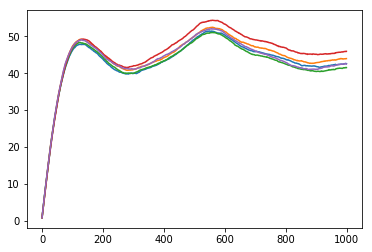

In [43]:
for sample in samples:
    plt.plot(sample)